In [ ]:
"""
We will discuss the following models

1. Binary Classifier
2. Multi-Class Classifier
3. Multi-Label Classifier
"""

In [1]:
## Getting classification data ready

from sklearn.datasets import make_circles

n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
# Printing the first 5 X and y values
print(X[:5], y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] [1 1 1 1 0]


In [3]:
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


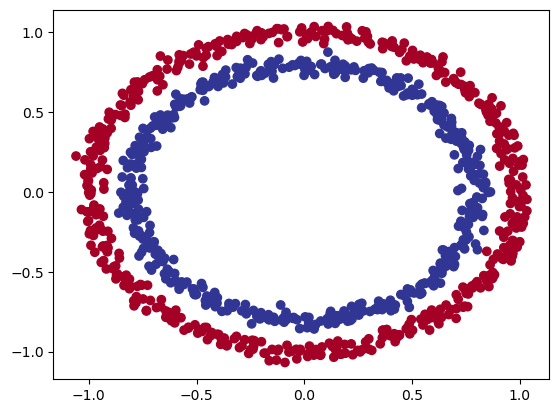

In [5]:
# Let plot them
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [6]:
## Turning data into tensors and creating - train,test splits

import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
# Lets build the model for the binary classification 

In [8]:
import torch
from torch import nn

# device agnostic
device = "gpu" if torch.cuda.is_available() else "cpu"

In [10]:
# construct the model class
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Creating two nn.Linear layers capable of handling X and y input and output
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # this means 5 hidden layers
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
## We can also use the nn.Sequential claas to perform the forward pass

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [12]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2807],
        [-0.2730],
        [-0.2992],
        [-0.2754],
        [-0.2967],
        [-0.2920],
        [-0.2725],
        [-0.2769],
        [-0.2992],
        [-0.2725]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [13]:
## Setting up loss function and optimizer

In [ ]:
"""
Since this model is a binary classification model, pytorch has  2 binary cross entropy implementations

1. torch.nn.BCELoss() - creates a loss function to mesaure the cross entropy between target and input
2. torch.nn.BCEWithLogitsLoss - same as above except has a sigmoid layer built in.
"""

In [14]:
# Creating a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create a optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [15]:
### Writing functions for computing evaluation metrics
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [16]:
## Lets train the model

In [20]:
torch.manual_seed(42)

epochs = 100

# Putting the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test   = X_test.to(device), y_test.to(device)

# Building a training and eval loop
for epoch in range(epochs):
    ## Training
    model_0.train()

    # 1.Forward pass
    y_logits = model_0(X_train).squeeze() # this has the actual values/logits
    y_pred = torch.round(torch.sigmoid(y_logits)) # this will give us 0 / 1 answer

    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    # Back Prop
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))


        # calculating loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc  = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss {loss: 5f}, Accuracy : {acc: .2f}% | Test loss: {test_loss: .5f},  Test acc: {test_acc: .2f}%") 


Epoch: 0 | Loss  0.702378, Accuracy :  50.00% | Test loss:  0.70161,  Test acc:  50.00%
Epoch: 10 | Loss  0.696517, Accuracy :  50.00% | Test loss:  0.69545,  Test acc:  50.00%
Epoch: 20 | Loss  0.694678, Accuracy :  50.00% | Test loss:  0.69335,  Test acc:  50.00%
Epoch: 30 | Loss  0.694057, Accuracy :  50.00% | Test loss:  0.69262,  Test acc:  50.00%
Epoch: 40 | Loss  0.693805, Accuracy :  43.00% | Test loss:  0.69239,  Test acc:  48.00%
Epoch: 50 | Loss  0.693668, Accuracy :  46.12% | Test loss:  0.69235,  Test acc:  49.50%
Epoch: 60 | Loss  0.693573, Accuracy :  46.38% | Test loss:  0.69239,  Test acc:  52.50%
Epoch: 70 | Loss  0.693497, Accuracy :  46.25% | Test loss:  0.69246,  Test acc:  52.00%
Epoch: 80 | Loss  0.693432, Accuracy :  46.62% | Test loss:  0.69255,  Test acc:  51.00%
Epoch: 90 | Loss  0.693376, Accuracy :  46.88% | Test loss:  0.69265,  Test acc:  51.00%


In [21]:
# The binary classifier doesn't seem to do well, hence we will want to visualize the decision boundry
# lets fetch this function from a remote github repo.

import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [23]:
from helper_functions import plot_predictions, plot_decision_boundary

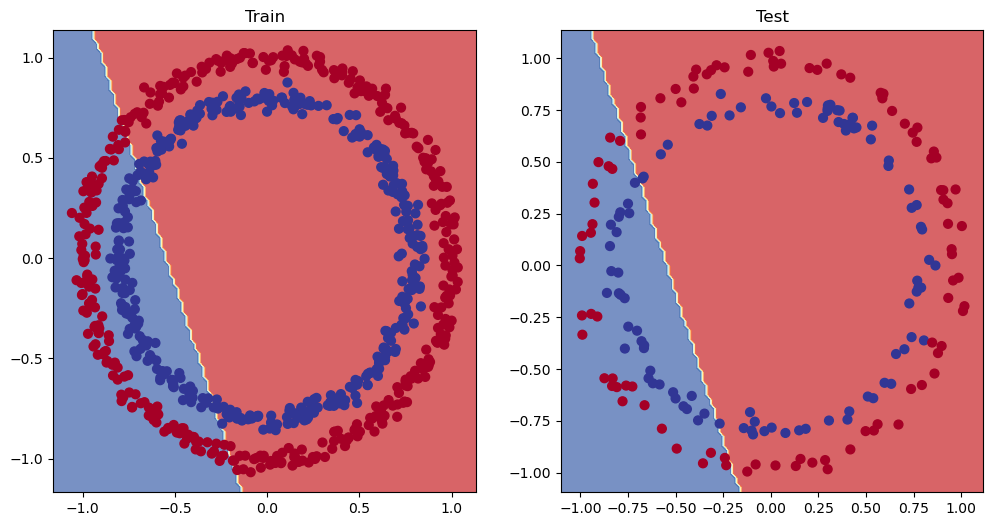

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [25]:
## Looks like we found the issue, we are trying to split the red and blue lines using a straight line...since our data is circular 
# i.e non linear, we cannot use a linear model to approximate it.

# Our model is currently under-fitting.

# we will need to introduce some non-linerity to our model - reLU ?

In [54]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=10)        
        self.layer_4 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_3 = CircleModelV2().to(device)
print(model_3)       

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [55]:
# Setting up the loss function and the optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.05)

In [58]:
### Training a model with non-linearity

torch.manual_seed(42)
epochs = 10000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test   = X_test.to(device), y_test.to(device)

In [59]:
for epoch in range(epochs):
    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculating the loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    optimizer.step()               

    ## Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc =  accuracy_fn(y_true=y_test, y_pred=test_pred) 

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.68982, Accuracy: 52.75% | Test Loss: 0.68883, Test Accuracy: 54.00%
Epoch: 100 | Loss: 0.68917, Accuracy: 53.00% | Test Loss: 0.68806, Test Accuracy: 54.00%
Epoch: 200 | Loss: 0.68845, Accuracy: 53.62% | Test Loss: 0.68718, Test Accuracy: 53.50%
Epoch: 300 | Loss: 0.68764, Accuracy: 53.87% | Test Loss: 0.68619, Test Accuracy: 53.50%
Epoch: 400 | Loss: 0.68672, Accuracy: 53.75% | Test Loss: 0.68506, Test Accuracy: 53.50%
Epoch: 500 | Loss: 0.68567, Accuracy: 53.87% | Test Loss: 0.68377, Test Accuracy: 53.50%
Epoch: 600 | Loss: 0.68447, Accuracy: 54.25% | Test Loss: 0.68231, Test Accuracy: 54.00%
Epoch: 700 | Loss: 0.68310, Accuracy: 54.50% | Test Loss: 0.68062, Test Accuracy: 54.00%
Epoch: 800 | Loss: 0.68149, Accuracy: 54.75% | Test Loss: 0.67858, Test Accuracy: 54.00%
Epoch: 900 | Loss: 0.67955, Accuracy: 55.25% | Test Loss: 0.67611, Test Accuracy: 54.50%
Epoch: 1000 | Loss: 0.67712, Accuracy: 56.00% | Test Loss: 0.67315, Test Accuracy: 56.50%
Epoch: 1100 | Loss: 0.

In [60]:
#Evaluation
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

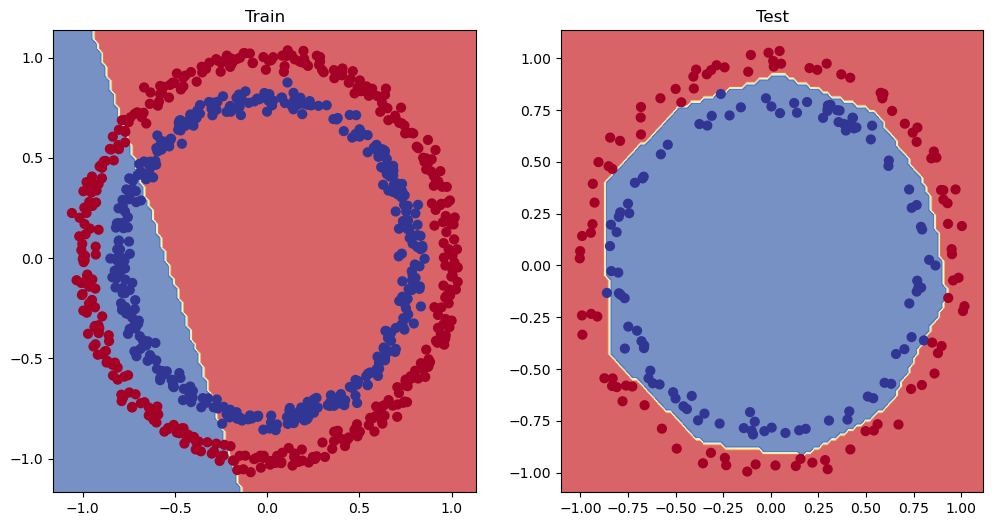

In [61]:
# Plotting
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

In [62]:
### Checking what a non-linear function does

In [63]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

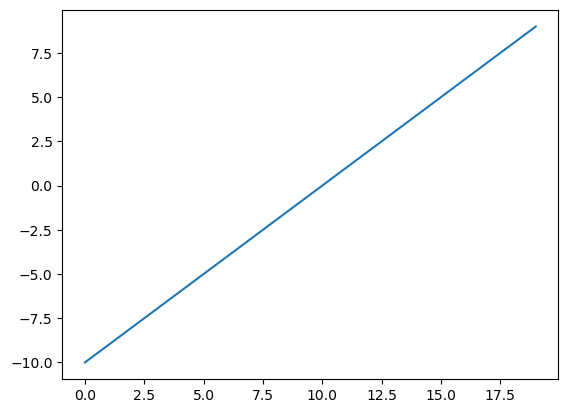

In [64]:
plt.plot(A)

In [66]:
def relu(x):
    """
    Note: with relu all the negative values will be zero
    """
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

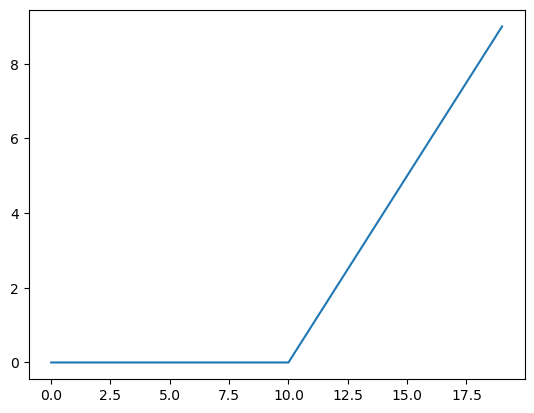

In [67]:
plt.plot(relu(A))

In [68]:
### Replocating sigmoid function
def sigmoid(x):
    return 1 / ( 1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

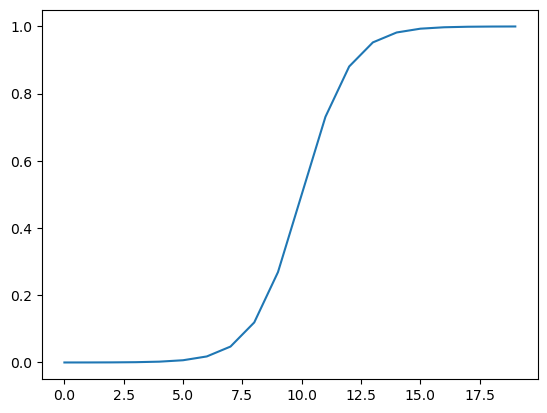

In [69]:
plt.plot(sigmoid(A))

In [70]:
### Creating a multi-class pytorch model

In [ ]:
"""
We will use make_blobs() function from sklearn to generate blobs (class), and use a classifier to classify the blobs
"""

In [71]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [76]:
# Set the hyperparam for data creation
NUM_CLASSES = 4
NUM_FEATUERES = 2
RANDOM_SEED = 42

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


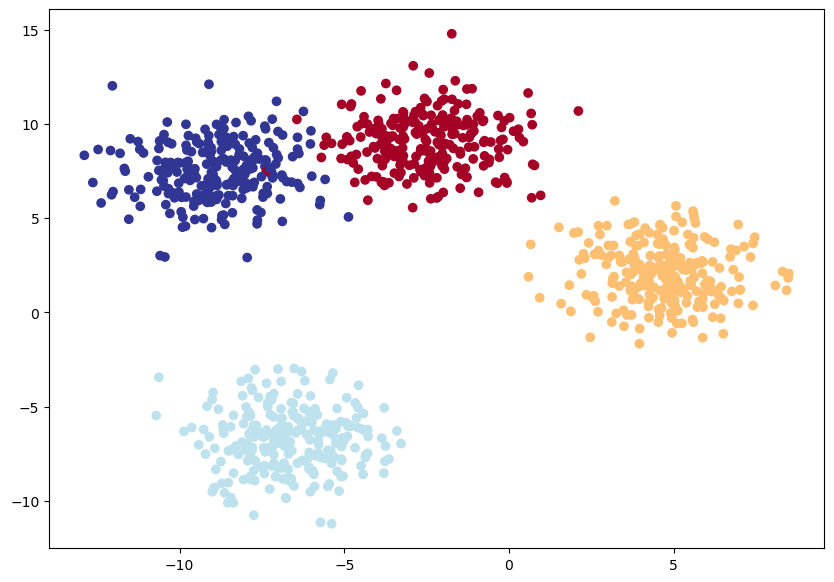

In [78]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [84]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [85]:
## Creating the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [86]:
### Creating a training and testing loop for the multi-class PyTorch Model

In [97]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.03185, Acc: 99.12% | Test Loss: 0.02293, Test Acc: 99.50%
Epoch: 10 | Loss: 0.03093, Acc: 99.12% | Test Loss: 0.02186, Test Acc: 99.50%
Epoch: 20 | Loss: 0.03017, Acc: 99.12% | Test Loss: 0.02097, Test Acc: 99.50%
Epoch: 30 | Loss: 0.02955, Acc: 99.12% | Test Loss: 0.02022, Test Acc: 99.50%
Epoch: 40 | Loss: 0.02902, Acc: 99.12% | Test Loss: 0.01958, Test Acc: 99.50%
Epoch: 50 | Loss: 0.02857, Acc: 99.12% | Test Loss: 0.01902, Test Acc: 99.50%
Epoch: 60 | Loss: 0.02819, Acc: 99.12% | Test Loss: 0.01852, Test Acc: 99.50%
Epoch: 70 | Loss: 0.02785, Acc: 99.12% | Test Loss: 0.01809, Test Acc: 99.50%
Epoch: 80 | Loss: 0.02756, Acc: 99.12% | Test Loss: 0.01770, Test Acc: 99.50%
Epoch: 90 | Loss: 0.02730, Acc: 99.12% | Test Loss: 0.01735, Test Acc: 99.50%


In [102]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(test_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


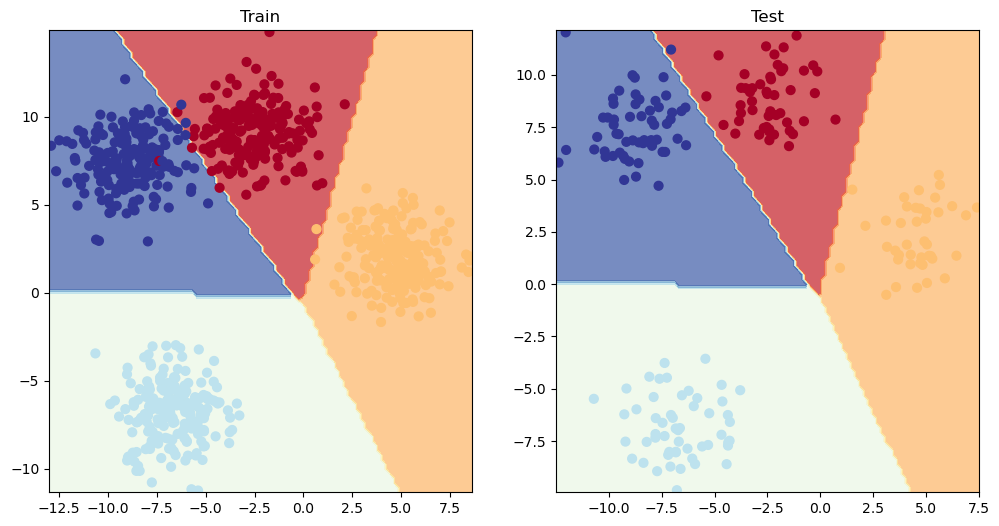

In [103]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [104]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)

In [ ]:
## Generating the confusion matrix

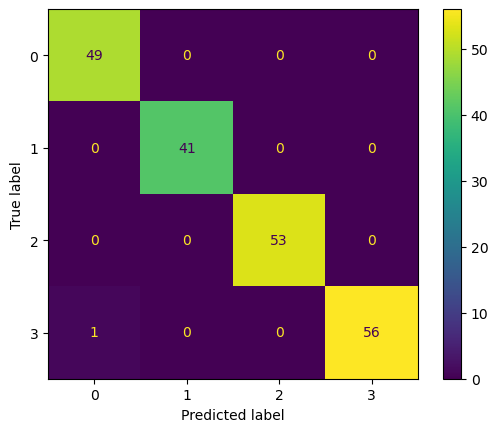

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_blob_test, y_preds, labels=range(NUM_CLASSES))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))
disp.plot()

plt.show()

In [107]:
y_blob_test[:10], y_preds[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

In [110]:
# Generating the classification report

In [111]:
from sklearn.metrics import classification_report
2
target_names = [f"class_{num}" for num in range(NUM_CLASSES)]

print(classification_report(y_blob_test, y_preds, target_names=target_names))

              precision    recall  f1-score   support

     class_0       0.98      1.00      0.99        49
     class_1       1.00      1.00      1.00        41
     class_2       1.00      1.00      1.00        53
     class_3       1.00      0.98      0.99        57

    accuracy                           0.99       200
   macro avg       0.99      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200

